<a href="https://colab.research.google.com/github/jungeun919/Pytorch_study/blob/main/Dacon/computer_vision/computer_vision_data2(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.cuda.amp import GradScaler

from torchvision import transforms
from torchvision.models import resnet101

# Customize Dataset

In [2]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: os.PathLike,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms

        self.labels = {}
        with open(image_ids, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = Image.open(
            os.path.join(self.dir, f'{str(image_id).zfill(5)}.png')).convert('RGB')
        target = np.array(self.labels.get(image_id)).astype(np.float32)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

# Image Augmentation

In [3]:
transforms_train = transforms.Compose([
    transforms.RandomRotation((90, 360)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine((0, 360)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [4]:
!unzip -qq /content/drive/MyDrive/Colab\ Notebooks/dacon/computer_vision/2차\ 배포/dirty_mnist_2nd.zip
!unzip -qq /content/drive/MyDrive/Colab\ Notebooks/dacon/computer_vision/2차\ 배포/mnist_data.zip
!unzip -qq /content/drive/MyDrive/Colab\ Notebooks/dacon/computer_vision/2차\ 배포/test_dirty_mnist_2nd.zip

trainset = MnistDataset('/content', '/content/drive/MyDrive/Colab Notebooks/dacon/computer_vision/2차 배포/dirty_mnist_2nd_answer.csv', transforms_train)
testset = MnistDataset('/content', '/content/drive/MyDrive/Colab Notebooks/dacon/computer_vision/2차 배포/sample_submission.csv', transforms_test)

train_loader = DataLoader(trainset,batch_size=32, num_workers=0)
test_loader = DataLoader(testset, batch_size=10, num_workers=0)

# Resnet 101

In [5]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet101(pretrained=True)
        self.classifier = nn.Linear(1000, 26)
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
# print(summary(model, (3, 256, 256)))

# Practice

In [7]:
import numpy as np

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MultiLabelSoftMarginLoss()

num_epochs = 20 # total: 25
scaler = GradScaler()
model.train()
for epoch in range(num_epochs):
    for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if (i+1) % 500 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).float().mean()
            print(f'{epoch}: {loss.item():.5f}, {acc.item():.5f}')

0: 0.68520, 0.54808
0: 0.64972, 0.59856
0: 0.62372, 0.61659
1: 0.58905, 0.66587
1: 0.56914, 0.67428
1: 0.56239, 0.68990
2: 0.51578, 0.73558
2: 0.47748, 0.76562
2: 0.51292, 0.74038
3: 0.48342, 0.75721
3: 0.45783, 0.77885
3: 0.48494, 0.75120
4: 0.46164, 0.77524
4: 0.41956, 0.79808
4: 0.44235, 0.79688
5: 0.40248, 0.82332
5: 0.39476, 0.82572
5: 0.42818, 0.79928
6: 0.42527, 0.81731
6: 0.35590, 0.82933
6: 0.41299, 0.80168
7: 0.36258, 0.83894
7: 0.36915, 0.84736
7: 0.37084, 0.83413
8: 0.37343, 0.82692
8: 0.35428, 0.84736
8: 0.38984, 0.83534
9: 0.34095, 0.85817
9: 0.31383, 0.86178
9: 0.34167, 0.84255
10: 0.33612, 0.85577
10: 0.32979, 0.86538
10: 0.33478, 0.85216
11: 0.30307, 0.87260
11: 0.28226, 0.87500
11: 0.34986, 0.84255
12: 0.33089, 0.85817
12: 0.28993, 0.87981
12: 0.30226, 0.86298
13: 0.31647, 0.86659
13: 0.30030, 0.87500
13: 0.31397, 0.86659
14: 0.30865, 0.87260
14: 0.30411, 0.87740
14: 0.28096, 0.88462
15: 0.30534, 0.86298
15: 0.28345, 0.88221
15: 0.30779, 0.86779
16: 0.30371, 0.87019
1

In [10]:
!pip install torch-lr-finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.20E-04


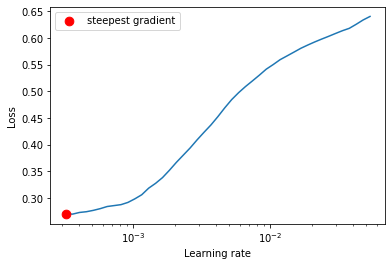

In [11]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [12]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/computer_vision/2차 배포/sample_submission.csv')

model.eval()
batch_size = test_loader.batch_size
batch_index = 0
for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon/computer_vision/2차 배포/sample_submission_5.csv', index=False)